# Performance and Energy Balance: A Comprehensive Study of State-of-the-Art Sound Event Detection Systems

This Jupyter Notebook report the code used for the analysis presented in the paper titled "Performance and Energy Balance: A Comprehensive Study of State-of-the-Art Sound Event Detection Systems".

The jupyter notebook preseneted the same results that the reader can find in the paper, with additional results that, for space imitations, they have not been possible to added the paper.

The Jupyter notebook will be divided by sections, following the same order as the one reported on the paper. 
Comments and notes will guide you through the results.

In order to successfully run the Jupyter Notebook, you will need to download the DCASE submission results for the year 2022 and 2023 and save them in a folder. 
You can download the DCASE 2023 results here: **NEED TO ADD LINK**


TO DO after ICASSP submission: 
- compare plot to compare the plots that now are plotte one by one
- add comment to the different plots

In [633]:
# importing necessary libraries
import pandas as pd
from pandas.io.json import json_normalize
from yaml import safe_load
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import string
import random
import plotly.express as px
import math

from plotly.subplots import make_subplots
import plotly.graph_objs as go

import plotly.io as pio
import os

In [634]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


In [635]:
# change the path to your local folder, where DCASE submission are saved
base_dir = Path("/Users/francescaronchini/Desktop/ICASSP24/SED/TUTORIAL/DCASE_submissions")

## Functions needed to run the analysis
We are going to define a series of functions that will be needed throughout the analysis. 

In [636]:
# scatter_plot function
def scatter_plot(
        df, 
        x, 
        y, 
        code, 
        title='',
        x_axes_lab=None, 
        y_axes_lab=None,
        type_xscale='log', 
        type_yscale='log',     
        scatter_mode=None, 
        return_fig=False, 
        unique_color=False, 
        marker_size = 10, 
        add_base=False
    ):
    '''
    This function takes a dataframe as input and creates a scatter plot using specified columns as x and y axes, 
    with additional customization options.

    :param df: The input dataframe.
    :param x: The column to be used as the x-axis values.
    :param y: The column to be used as the y-axis values.
    :param code: The column to determine wwhich data are the color of data points.
    :param title: The title of the scatter plot.
    :param x_axes_lab: Label for the x-axis.
    :param y_axes_lab: Label for the y-axis.
    :param type_xscale: Scale type for the x-axis ('log' or 'linear').
    :param type_yscale: Scale type for the y-axis ('log' or 'linear').
    :param scatter_mode: Scatter mode (None, 'lines', 'markers', 'lines+markers').
    :param return_fig: If True, the function returns the plot object; if False, it displays the plot.
    :param unique_color: If True, all data points are plotted with the same color (blue); if False, colors are assigned based on a predefined sequence.
    :param marker_size: Size of markers in the scatter plot.
    :param add_base: If True, additional data points for the 'Baseline' and 'Baseline (AudioSet)' are added to the plot.
    '''
    
    
    # Define the color sequence based on the 'unique_color' parameter.
    if unique_color:
        color_discrete_sequence = color_discrete_sequence=["blue"]
    else:
        color_discrete_sequence = px.colors.qualitative.Alphabet

    # Create the scatter plot using Plotly Express.
    fig = px.scatter(df, x=x, y=y, color=code, color_discrete_sequence=color_discrete_sequence)

    # If 'add_base' is True, add additional data points for 'Baseline' and 'Baseline (AudioSet)' to the plot.
    if add_base:
        baseline = df[df['code'] == 'Baseline_task4a_1']
        baseline_2  = df[df['code'] == 'Baseline_task4a_2']

        colors = {
            'colors': ['red', 'green'], 
            }

        for index, (base, text) in enumerate(zip([baseline, baseline_2], ['Baseline', 'Baseline (AudioSet)'])):
            fig.add_trace(
                go.Scatter(
                    x=base[x],
                    y=base[y],
                    text=text,
                    name=text,
                    showlegend=True,
                    type= 'scatter',
                    mode= 'markers',
                    marker_size=marker_size,
                    marker= {'color': colors['colors'][index]},
                ),
            )
    
    # Customize the plot's appearance.
    fig.update_traces(marker_size=marker_size)
    fig.update_layout(scatter_mode, title=title, title_x=0.3)
    fig.update_xaxes(title_text=x_axes_lab, type=type_xscale)
    fig.update_yaxes(title_text=y_axes_lab, type=type_yscale)
    
    # If 'return_fig' is True, return the plot object; otherwise, display the plot.
    if return_fig:
        return fig
    else:
        return fig.show()
    

In [637]:
## convert string to an int number
def convert_suffix_to_int(number_str):
    '''
    Converts a string representing a number with a suffix (K, M, B) to an integer.

    Parameters:
    number_str (str): The input string representing a number with an optional suffix.

    Returns:
    int: The converted integer value.
    '''
    # Define suffixes and their corresponding multipliers.
    suffixes = {'K': 10**3, 'M': 10**6, 'B': 10**9}

    # Check if the input is a string and ends with a valid suffix ('K', 'M', 'B').
    if isinstance(number_str, str) and (number_str[-1] in suffixes or number_str[-1] == 'B'):
        # Convert the input string to uppercase for consistency.
        number_str = number_str.upper()

        # Check if the suffix is 'B' (billion) or other suffixes ('K' for thousand, 'M' for million).
        if number_str[-1] == 'B':
            # If the suffix is 'B', use the 'M' multiplier (billion) and convert the value to an integer.
            multiplier = suffixes['M']
            value = int(float(number_str[:-1]) * multiplier)
        else:
            # For 'K' and 'M' suffixes, use the respective multipliers and convert the value to an integer.
            multiplier = suffixes[number_str[-1]]
            value = int(float(number_str[:-1]) * multiplier)
        
        return value
    else:
        # If the input is not a string or does not end with a valid suffix, convert it to an integer directly.
        return int(number_str)


In [638]:
# print_df function
def print_df(df):
    '''
    Prints a styled representation of a DataFrame with a hover effect on rows.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to be printed.

    Returns:
    pandas.io.formats.style.Styler: A styled representation of the DataFrame.
    '''
    # Apply a yellow background color to rows when hovered over.
    styled_df = df.style.set_table_styles([
        {'selector': 'tr:hover', 'props': [('background-color', 'yellow')]}
    ])
    
    # Return the styled DataFrame.
    return styled_df


In [639]:
# Define a function 'round_to' that rounds a given 'value' to the specified number of 'decimal_places'
def round_to(value, decimal_places):
    return round(value, decimal_places)

In [640]:
# Function to determine whether a system is part of an ensemble.
# This function takes a value as input and returns "yes" if the value is not None,
# indicating that the system is part of an ensemble, or "no" if the value is None, indicating that the system is not part of an ensemble.
def define_ensemble(value):
    '''
    Function to determine whether a system is part of an ensemble.
    This function takes a value as input and returns "yes" if the value is not None,
    indicating that the system is part of an ensemble, or "no" if the value is None, 
    indicating that the system is not part of an ensemble.
    '''
    value_ret = "no" if value == None else "yes"
    return value_ret


In [641]:
# print_statistics function
def print_statistics(dfs_list, dfs_name, add_columns=None):
    '''
    Calculate and print statistics for selected columns in one or more DataFrames.

    Parameters:
    dfs_list (list of pandas.DataFrame): A list of DataFrames to calculate statistics for.
    dfs_name (list of str): A list of names corresponding to each DataFrame.
    add_columns (str or None, optional): An additional column to include in the statistics.

    Returns:
    None
    '''
    # Iterate through the list of DataFrames and their corresponding names.
    for df, name in zip(dfs_list, dfs_name):
        
        # Define the selected columns for which statistics will be calculated.
        selected_columns = ['system_complexity', 'energy_training', 'energy_test']
        
        # If an additional column is specified, add it to the selected columns.
        if add_columns:
            selected_columns.append(add_columns)
        
        # Calculate descriptive statistics for the selected columns.
        statistics = df[selected_columns].describe()
    
        # Rename the '50%' row to 'median' for clarity.
        statistics.rename(index={'50%': 'median'}, inplace=True)
    
        # Print the statistics for the current DataFrame.
        print(f"Statistics for DataFrame {name} in terms of the metric considered")
        
        # Format the statistics to display three decimal places.
        formatted_statistics = statistics.applymap(lambda x: f'{x:.3f}')
        print(formatted_statistics)
        print('\n')


In [642]:
# Function to compare data from two dataframes for 2022 and 2023

def scatter_compare(
    df1, 
    df2,
    x_lab,          
    y_lab,          
    x_axes_lab,     
    y_axes_lab,     
    code,           
    title,          
    x_lab_2=None,   
    y_lab_2=None,   
    x_axes_lab_2=None,  
    y_axes_lab_2=None,  
    type_xaxes='linear',    
    type_yaxes='linear',    
    marker_size=10,         
    rows=1,                 
    columns=2,              
    add_base=False,         
    comp_22_23=False,       
    year=None,              
    show=True               
):
    '''
    Function to compare data from two dataframes for 2022 and 2023.

    Parameters:
        df1: DataFrame - First dataframe containing data for comparison.
        df2: DataFrame - Second dataframe containing data for comparison.
        x_lab: str - X-axis label for the first dataframe.
        y_lab: str - Y-axis label for the first dataframe.
        x_axes_lab: str - X-axis title for the first subplot.
        y_axes_lab: str - Y-axis title for the first subplot.
        code: str - Column name for code in dataframes.
        title: str - Title for the plot.
        x_lab_2: str, optional - X-axis label for the second dataframe (default: same as df1).
        y_lab_2: str, optional - Y-axis label for the second dataframe (default: same as df1).
        x_axes_lab_2: str, optional - X-axis title for the second subplot (default: same as x_axes_lab).
        y_axes_lab_2: str, optional - Y-axis title for the second subplot (default: same as y_axes_lab).
        type_xaxes: str, optional - X-axis scale type (default: 'linear').
        type_yaxes: str, optional - Y-axis scale type (default: 'linear').
        marker_size: int, optional - Marker size for scatter plots (default: 10).
        rows: int, optional - Number of rows in subplot grid (default: 1).
        columns: int, optional - Number of columns in subplot grid (default: 2).
        add_base: bool, optional - Whether to add baseline data to the plot (default: False).
        comp_22_23: bool, optional - Whether to compare 2022 and 2023 data (default: False).
        year: str, optional - Year for comparison (default: None).
        show: bool, optional - Whether to show the plot (default: True).

    Returns:
        None (if show=True) or plotly.graph_objs._figure.Figure (if show=False).
    '''

    # Check if we are comparing 2022 and 2023 data
    if comp_22_23:
        # Separate baseline data for 2022
        baseline_df1 = df1[df1['code'] == 'Baseline']
        baseline_df1_as = df1[df1['code'] == 'Baseline (AudioSet)']

        # Separate baseline data for 2023
        baseline_df2 = df2[df2['code'] == 'Baseline_task4a_1']
        baseline_df2_as = df2[df2['code'] == 'Baseline_task4a_2']
    else:
        # If not comparing, assign data based on the specified year
        if year == '2022':
            baseline_df1 = baseline_df2 = df1[df1['code'] == 'Baseline']
            baseline_df1_as = baseline_df2_as = df1[df1['code'] == 'Baseline (AudioSet)']
        else:
            baseline_df1 = df1[df1['code'] == 'Baseline_task4a_1']
            baseline_df1_as = df1[df1['code'] == 'Baseline_task4a_2']
            baseline_df2 = baseline_df1
            baseline_df2_as = baseline_df1_as

    # Set default labels and titles if not provided
    if not x_lab_2:
        x_lab_2 = x_lab

    if not y_lab_2:
        y_lab_2 = y_lab

    if not x_axes_lab_2:
        x_axes_lab_2 = x_axes_lab

    if not y_axes_lab_2:
        y_axes_lab_2 = y_axes_lab

    # Define colors for plots
    colors = {
        'colors': ['#231AB9', '#FE6100'], 
    }
    
    # Initialize figure with subplots
    fig = make_subplots(
        rows=rows, cols=columns,
        column_widths=[0.5, 0.5],
        row_heights=[0.3],
        specs=[
                [{"type": "scatter", "rowspan": 1},{"type": "scatter", "rowspan": 1}],
              ]
        )
    
    # Add the first dataframe to the first subplot
    fig.add_trace(
        go.Scatter(
                x=df1[x_lab],
                y=df1[y_lab],
                text=df1[code],
                type= 'scatter',
                mode= 'markers',
                name= 'Submissions entries',
                marker_size=marker_size,
                marker= {'color': 'black'},
            ),
        row=1, col=1
    )
    
    # Add baseline data to the first subplot if requested
    if add_base:
        for index, (base, text) in enumerate(zip([baseline_df1, baseline_df1_as], ['Baseline', 'Baseline (AudioSet)'])):
            fig.add_trace(
                go.Scatter(
                        x=base[x_lab],
                        y=base[y_lab],
                        text=text,
                        name=text, 
                        type= 'scatter',
                        mode= 'markers',
                        marker_size=marker_size,
                        marker= {'color': colors['colors'][index]},
                    ),
                row=1, col=1
            )
    
    # Add the second dataframe to the second subplot
    fig.add_trace(
        go.Scatter(
                x=df2[x_lab_2],
                y=df2[y_lab_2],
                text=df2[code],
                type= 'scatter',
                showlegend=False,
                mode= 'markers',
                marker_size=marker_size,
                marker= {'color': 'black'},
            ),
        row=1, col=2
    )

    # Add baseline data to the second subplot if requested
    if add_base:
        for index, (base, text) in enumerate(zip([baseline_df2, baseline_df2_as], ['Baseline', 'Baseline (AudioSet)'])):
            fig.add_trace(
                go.Scatter(
                        x=base[x_lab_2],
                        y=base[y_lab_2],
                        text=text,
                        showlegend=False,
                        type= 'scatter',
                        mode= 'markers',
                        marker_size=marker_size,
                        marker= {'color': colors['colors'][index]},
                    ),
                row=1, col=2
            )
    
    # Set the plot title
    fig.update_layout(title=title, title_x=0.23)
    
    # Add x-label and y-label to the first subplot
    fig.update_xaxes(title_text=x_axes_lab, type=type_xaxes, row=1, col=1)
    fig.update_yaxes(title_text=y_axes_lab, type=type_yaxes, row=1, col=1)

    # Add x-label and y-label to the second subplot
    fig.update_xaxes(title_text=x_axes_lab_2, type=type_xaxes, row=1, col=2)
    fig.update_yaxes(title_text=y_axes_lab_2, type=type_yaxes, row=1, col=2)

    # Show or return the plot based on the 'show' parameter
    if show:
        fig.show()
    else:
        return fig


In [643]:
# Define a function 'scatter_all' for creating scatter plots and comparing data for 2022 and 2023.
def scatter_all(
    df,             # Input DataFrame containing the data to be plotted.
    x_lab,          # Column name for the x-axis data.
    y_lab,          # Column name for the y-axis data.
    x_axes_lab,     # Label for the x-axis.
    y_axes_lab,     # Label for the y-axis.
    code,           # Column name for code or labels to be displayed on the plot.
    title=None,     # Optional title for the plot.
    type_xaxes='log',   # Type of x-axis scale (e.g., 'log' for logarithmic).
    type_yaxes='log',   # Type of y-axis scale (e.g., 'log' for logarithmic).
    marker_size=10,     # Size of data points/markers on the plot.
    rows=1,             # Number of rows in the subplot grid.
    columns=1,          # Number of columns in the subplot grid.
    add_base=False,     # Whether to add baseline data to the plot.
    comp_22_23=True,    # Whether to compare data for 2022 and 2023.
    year=None,          # Optional year to specify the data year.
    show=True           # Whether to display the plot or return the figure object.
):

    # Extract baseline data for comparison if 'add_base' is True.
    baseline = df[df['code'] == 'Baseline_task4a_1']
    baseline_2 = df[df['code'] == 'Baseline_task4a_2']

    # Define colors for the baseline data.
    colors = {
        'colors': ['#231AB9', '#FE6100'],
    }

    # Initialize a subplot figure using Plotly.
    fig = make_subplots(
        rows=rows, cols=columns,
        column_widths=[1],
        row_heights=[0.3],
        specs=[
            [{"type": "scatter", "rowspan": 1}]
        ]
    )

    # Add the main dataframe to the subplot.
    fig.add_trace(
        go.Scatter(
            x=df[x_lab],
            y=df[y_lab],
            text=df[code],
            type='scatter',
            mode='markers',
            name='Entries (2023)',
            marker_size=marker_size,
            marker={'color': 'black'},
        ),
        row=1, col=1
    )

    # If 'add_base' is True, add baseline data to the subplot.
    if add_base:
        for index, (base, text) in enumerate(zip([baseline, baseline_2], ['Baseline', 'Baseline (A+B)'])):
            fig.add_trace(
                go.Scatter(
                    x=base[x_lab],
                    y=base[y_lab],
                    text=text,
                    name=text,
                    type='scatter',
                    mode='markers',
                    marker_size=marker_size,
                    marker={'color': colors['colors'][index]},
                ),
                row=1, col=1
            )

    # Update layout settings for the plot.
    fig.update_layout(title=title, title_x=0.23, showlegend=True)
    fig.update_xaxes(title_text=x_axes_lab, type=type_xaxes, row=1, col=1)
    fig.update_yaxes(title_text=y_axes_lab, type=type_yaxes, row=1, col=1)

    # Display the plot if 'show' is True; otherwise, return the figure object.
    if show:
        fig.show()
    else:
        return fig


In [644]:
def custom_format(x):
    if abs(x) >= 1e12:
        return f'{x:.2e}'
    else:
        return f'{x:.2f}'

## GENERAL COMPARISON BETWEEN DCASE 2022 AND DCASE 2023 SYSTEMS

This section analyzes all entries from 2022 and 2023 to understand how energy-related metrics have evolved over the past two years. In this study, we compare basic metrics such as median, 25th percentile, and 75th percentile, for system complexity, energy consumption during training, and energy consumption during testing. 

### Collecting 2022 submissions

In [645]:
# Specify the filename for the 2022 data file
fname_22 = 'results_task4_entries.yaml'

# Construct the full path to the 2022 data file using 'base_dir'
fname_22 = base_dir / "2022" / fname_22

# Open and read the 2022 data file in YAML format
with open(fname_22, 'r') as f:
    # Load the data and normalize it into a DataFrame using json_normalize
    df_all_22 = json_normalize(safe_load(f))

# Define a list of columns to format with rounding
columns_to_format = ['energy_training', 'energy_test', 'PSDS_1_all', 'PSDS_2_all']

# Define the number of decimal places for rounding
decimal_places = 3

# Apply the 'round_to' function to round the specified columns to the specified decimal places
df_all_22[columns_to_format] = df_all_22[columns_to_format].apply(round_to, args=(decimal_places, ))


In [646]:
# Define a list of columns we want to select from the DataFrame
columns_list = ["energy_training", "energy_test", "system_complexity", "code", "system_ensemble_method_subsystem_count", "PSDS_1_all", "PSDS_2_all"]

# Create a new DataFrame 'df_e_22' by selecting only the specified columns from 'df_all_22'
df_22 = df_all_22[columns_list]

In [647]:
# Manually process the 'system_complexity' column for some entries to standardize its values
df_22.loc[df_22['system_complexity'] == '1.7MB', 'system_complexity'] = '1.7M'
df_22.loc[df_22['system_complexity'] == '1.1MB', 'system_complexity'] = '1.1M'
df_22.loc[df_22['system_complexity'] == '4.2MB', 'system_complexity'] = '4.2M'
df_22.loc[df_22['system_complexity'] == 'Trainable 1.7 M non-Trainable 1.7M', 'system_complexity'] = '3.4M'
df_22.loc[df_22['system_complexity'] == 'Trainable 1.1 M non-Trainable 1.1M', 'system_complexity'] = '2.2M'

Certain entries in the dataset either share identical system complexities (likely indicating multiple submissions using the same system) or lack information regarding energy consumption, as it wasn't obligatory at the time. To address this, we perform the following data adjustments:

- Remove any entries with missing values for energy consumption.
- Convert measurements in MB, M, or K to integer values.
- Eliminate duplicate entries.

In [648]:
# Reset the index of DataFrame 'df_e_22' and drop the previous index
df_22.reset_index(inplace=True, drop=True)

# Display the number of entries in the DCASE 2022 dataset
print(f"Total DCASE 2022 entries: {len(df_22)}\n")

# Define a subset of columns containing 'system_complexity', 'energy_training', and 'energy_test'
subset = ['system_complexity', 'energy_training', 'energy_test']

# Remove rows with null (missing) values in the specified subset of columns
df_22.dropna(subset=subset, inplace=True)

# Convert 'system_complexity' values to integer representations by removing suffixes
df_22[subset[0]] = df_22[subset[0]].apply(convert_suffix_to_int)

# Remove duplicate rows based on the specified subset of columns
df_22.drop_duplicates(subset=subset, inplace=True)

# Reset the index of DataFrame 'df_e_22' again and drop the previous index
df_22.reset_index(inplace=True, drop=True)


Total DCASE 2022 entries: 101



In [649]:
print(f"After the processing we got {len(df_22)} entries to analyze")

# Optionally plot the df_22 Dataframe uncommenting the following line
#print_df(df_22)

After the processing we got 60 entries to analyze


### Collecting 2023 submission

In [650]:
# Read the data from two files in 2023 and concatenate them

# Define the filenames for the energy-related data and non-ensemble data in 2023
fname_23_e = 'results_task4a_entries.yaml'
fname_23_e = base_dir / "2023" / fname_23_e

fname_23 = 'results_task4a_entries_nonensemble.yaml'
fname_23 = base_dir / "2023" / fname_23

# Open and read the energy-related data from 'fname_23_e' and normalize it into 'full_df_e'
with open(fname_23_e, 'r') as f:
    full_df_e = json_normalize(safe_load(f))

# Open and read the non-ensemble data from 'fname_23' and normalize it into 'full_df'
with open(fname_23, 'r') as f:
    full_df = json_normalize(safe_load(f))

# Concatenate 'full_df' and 'full_df_e' to create 'df_all_23' containing all 2023 data
df_all_23 = pd.concat([full_df, full_df_e])


In [651]:
# Define a list of columns to round to a specified number of decimal places
columns_to_round = ['energy_training', 'energy_test', 'energy_training_normalized', 'energy_test_normalized']

# Specify the number of decimal places for rounding
decimal_places = 3

# Apply the 'round_to' function to round the values in the specified columns to the specified decimal places
df_all_23[columns_to_round] = df_all_23[columns_to_round].apply(round_to, args=(decimal_places,))


In [652]:
# Select a subset of columns from the DataFrame
columns_list = ["energy_training", "energy_test", "system_complexity_params", "system_name", "system_ensemble_method_subsystem_count", "psds1_eval_full", "psds2_eval_full"]

# Extract numeric values from columns 'psds1_eval_full' and 'psds2_eval_full' and convert them to float
for label in ['psds1_eval_full', 'psds2_eval_full']:
    df_all_23[label] = df_all_23[label].str.extract(r'(\d+\.\d+)')
    df_all_23[label] = df_all_23[label].astype(float)

# Create a new DataFrame 'df_23' containing the selected columns
df_23 = df_all_23[columns_list]

# Rename columns to match the naming convention used in the 2022 DataFrame
df_23.rename(columns={'system_name': 'code', 'system_complexity_params': 'system_complexity', 'psds1_eval_full': 'PSDS_1_all', 'psds2_eval_full': 'PSDS_2_all'}, inplace=True)

# Reset the index of DataFrame 'df_23' and drop the previous index
df_23.reset_index(inplace=True, drop=True)

# Display the number of entries in the DCASE 2023 dataset
print(f"Total DCASE 2023 entries: {len(df_23)}\n")


Total DCASE 2023 entries: 123



We preprocess the dataframe in order to: 
- remove the duplicates
- remove any null data for the dataframe we are considering

In [653]:
# Remove duplicate rows in DataFrame 'df_23' based on the specified subset of columns
df_23.drop_duplicates(subset=subset, inplace=True)

# Reset the index of DataFrame 'df_23' and drop the previous index
df_23.reset_index(inplace=True, drop=True)

In [654]:
# Optionally print the df_23 Dataframe uncommenting the following line
#print_df(df_22)

In [655]:
print(f"After the pre-process of the data we are able to analysize: \n")
print(f"DCASE 2022 entries (filtered): {len(df_22)}\n")
print(f"DCASE 2023 entries (filtered): {len(df_23)}\n")

After the pre-process of the data we are able to analysize: 

DCASE 2022 entries (filtered): 60

DCASE 2023 entries (filtered): 64



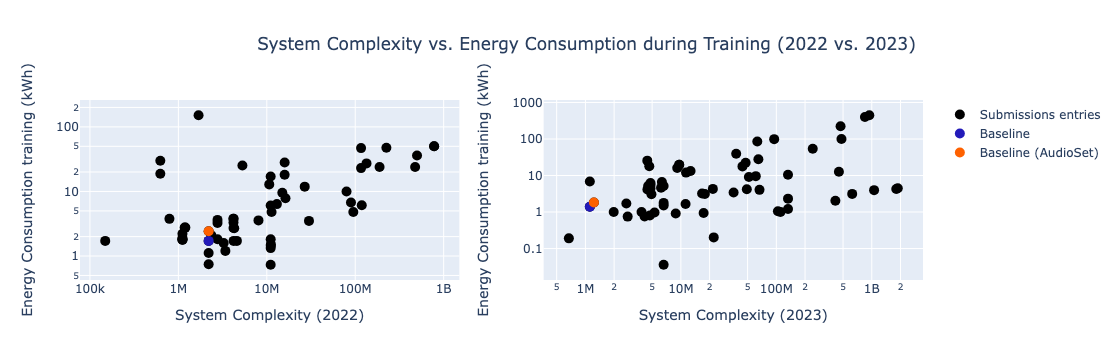

In [656]:
# Plotting System Complexity Comparison for 2022 and 2023 - Energy Consumption during Training

# Set the scale type for the x and y axes
type_xaxes = 'log'
type_yaxes = 'log'

# Define labels for the x and y axes
x_axes_lab = 'System Complexity (2022)'
x_axes_lab_2 = 'System Complexity (2023)'
y_axes_lab = 'Energy Consumption training (kWh)'

# Specify the columns to consider from the dataframes
df_x = 'system_complexity'
df_y = 'energy_training'

# Define the title for the figure
title = f'System Complexity vs. Energy Consumption during Training (2022 vs. 2023)'
text = 'code'

# Call the scatter_compare function to create the comparison plot
scatter_compare(df_22, df_23, df_x, df_y, x_axes_lab, y_axes_lab, text, title, x_axes_lab_2=x_axes_lab_2, type_xaxes=type_xaxes, type_yaxes=type_yaxes, add_base=True, comp_22_23=True)


From the plot is possible to see that the system complexity increase in terms of range for the 2023, as well as the energy consumed at training. Evene if the plot shows that there is tendency in increasing the training consumptionm if the system complexity increases, this cannot be generally confirmed. In fact, there are several systems with a complexity in terms of parameters higheer than 100 M that have a less energy impact of systems whit a system complexity of 1 M. 
So it is not possible to make any conclusion in terms of relation between system complexity snf energy consumption. 

In general, also the complexity of the systems tends to increase, even if main of the density keeps staying in the middle. 

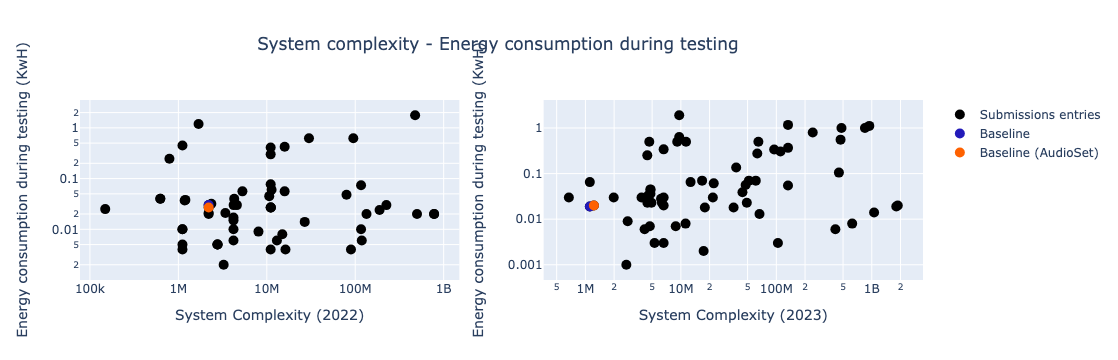

In [657]:
# Plotting system complexity data for 2022 and 2023 - Energy consumption during testing.

# Define the column name for the y-axis data and its corresponding label.
df_y = 'energy_test'
y_axes_lab = 'Energy consumption during testing (KwH)'

# Construct the plot title without a figure number.
title = 'System complexity - Energy consumption during testing'

# Call the 'scatter_compare' function to create the scatter plot.
scatter_compare(df_22, df_23, df_x, df_y, x_axes_lab, y_axes_lab, text, title, x_axes_lab_2=x_axes_lab_2, type_xaxes=type_xaxes, type_yaxes=type_yaxes,
                add_base=True, comp_22_23=True)


From the plot is possible to see that while the system complexity increase in terms of range for the 2023, the energy consumed at testing stays more or less in the same range, even if there is an higer concentratiion of systems consuming between 0.1 and 2 kWH at testing.
Anyway, this plot confirms that it is not possible to make any conclusions in terms of relation between system complexity and cosnumption. 

In general, also the complexity of the systems thends to increase, even if main of the density keeps staying in the middle. 

### General statistics for 2022 and 2023 systems

In [658]:
# print statistics for dataframe 
print_statistics([df_22, df_23], ['DCASE_22', 'DCASE_23'])

Statistics for DataFrame DCASE_22 in terms of the metric considered
       system_complexity energy_training energy_test
count             60.000          60.000      60.000
mean        66867695.167          12.960       0.121
std        164530606.436          22.642       0.297
min           148852.000           0.733       0.002
25%          2200000.000           1.815       0.010
median       6676303.000           3.699       0.026
75%         18903660.000          17.291       0.046
max        780237640.000         151.415       1.772


Statistics for DataFrame DCASE_23 in terms of the metric considered
       system_complexity energy_training energy_test
count             64.000          64.000      64.000
mean       167357893.125          28.109       0.211
std        379777002.250          79.355       0.366
min           671000.000           0.036       0.001
25%          4804956.000           1.617       0.019
median      14662273.000           4.295       0.035
75%         97

The values showed in this table confirm the previous comments regarding the fact that it is obvious that the systems increase in terms of size, in terms of energy consumption at trainign and in terms of energy consumption at testing. 
Anyway, it is not really trustable to consider mean and standard deviation of this analysis because .... 
In fact, the variability of data is really big. It makes more sense to analyze the reuslts in terms of median, 25th percentile and 75th percentile. 

In this case, we can observe how for system complexity the 25th percentile for the DCASE 2023 submissions is more than the double values of the 25th percentile of the DCASE 2022 submissions. Also the 75th got bigger, together with the median values, overcomign by more than two times the median of the previous year. 

Different conclusion coul be driven for the energy at trainign and testing, but those values are not normalzied so they are not really objective evaluation and we cannot really consider them to draw conclusion on the trend in the llast two years for this particular metrics.

## RELATION BETWEEN SYSTEM COMPLEXITY, MACS, AND ENERGY CONSUMPTION

In 2023 we made the energy consumption metric mandatory and we also ask for the MACs in order to have a more objective metric for comparison. 
We also asked participants to normalize the energy to the baseline. Metrics that have been introduced:
- MACS
- the energy has been normalized by the baseline

We will consider only the energy normalized from this moment and we are going to focus our analyses on the DCASE 2023 submissions, because of fairness and because of objectivities in metrics.

In [659]:
# Define a list of column names that we are interested in from the DataFrame.
columns_name = ['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params', 'system_ensemble_method_subsystem_count', 'code']

# Define a subset of columns that we want to consider for analysis.
subset = ['system_complexity_params', 'energy_training_normalized', 'energy_test_normalized']

# Create a new DataFrame 'df_only_23' by selecting only the columns specified in 'columns_name' from 'df_all_23'.
df_only_23 = df_all_23[columns_name]

# Remove duplicate rows from 'df_only_23' based on the columns specified in 'subset'.
df_only_23.drop_duplicates(subset=subset, inplace=True)

# Reset the index of 'df_only_23' after dropping duplicates and discard the previous index.
df_only_23.reset_index(inplace=True, drop=True)

# Optionally, print the resulting DataFrame 'df_only_23'.
# Uncomment the line below to print the DataFrame.
# print_df(df_only_23)


In [660]:
# Specify the file format (e.g., 'png', 'pdf', 'jpeg', 'svg', etc.) to save the images that we are going to generate
file_format = 'jpg'
fig_dir = "./PAPER/Fig"

width=500
height=250

### Relation between system complexity and energy at training

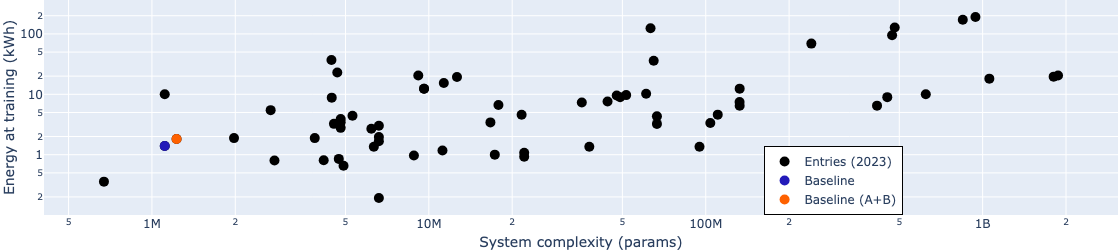

In [661]:
# Define the variables for the scatter plot.
x = 'system_complexity_params'       # X-axis data column
y = 'energy_training_normalized'     # Y-axis data column
figure = 1                           # Figure number

# Define labels for the x and y axes.
x_axes_lab = 'System complexity (params)'
y_axes_lab = 'Energy at training (kWh)'

# Column containing code or labels to be displayed on the plot.
code = 'code'

# Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
fig = scatter_all(df_only_23, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)

# Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
fig.update_layout(
    legend=dict(
        x=0.67,                    # Adjust the x-coordinate to position the legend horizontally
        y=0,                       # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",       # Set the border color (you can use any valid color)
        borderwidth=1,             # Set the border width
    )
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    width=width,                    # Adjust the width as needed
    height=height,                  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
)

# Display the figure.
fig.show()

# Specify the directory for saving the figure and the file name.
file_name = os.path.join(fig_dir, 'sc_etr.png')

# Save the figure to the specified file with a defined format and scaling.
pio.write_image(fig, file_name, format=file_format, scale=3)

From the plot is observe that the system complexity does not relate in a straighforward way to the enrgy consumed at training.
In fact, there are systems with a complexity of 5 M parameters that consumes more energy than systems with a complexity of 1 B parameters. This indicates that it is not possible to consider the system complexity as a solid metric to predict the enrgy consumption.

### Relation between system complexity and energy at testing

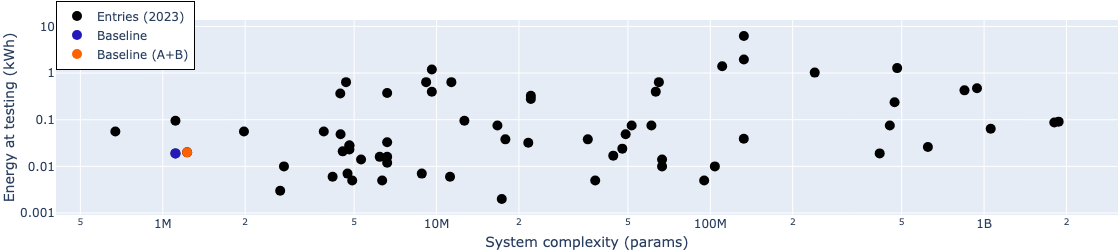

In [662]:
# Define the variables for the scatter plot.
y = 'energy_test_normalized'         # Y-axis data column

# Define labels for the x and y axes.
y_axes_lab = 'Energy at testing (kWh)'

# Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
fig = scatter_all(df_only_23, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)

# Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
fig.update_layout(
    legend=dict(
        x=0.00,                    # Adjust the x-coordinate to position the legend horizontally
        y=1.1,                       # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",       # Set the border color (you can use any valid color)
        borderwidth=1,             # Set the border width
    )
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    width=width,                    # Adjust the width as needed
    height=height,                  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
)

# Display the figure.
fig.show()

# Specify the directory for saving the figure and the file name.
file_name = os.path.join(fig_dir, 'sc_ete.png')

# Save the figure to the specified file with a defined format and scaling.
pio.write_image(fig, file_name, format=file_format, scale=3)

The plot shows how it is possible to observe the same behavior as the previous one also for the energy at testing. 
The distribution between the energy consumed is more or less the same so if we know how much a system is consumign at training, it is possible to predict how much it will consume at testing. Anyway, the system complexity metric does not have a linear and positive relation with the energy consumed at trainign or a testing. 

### Relation between MACs and energy at training

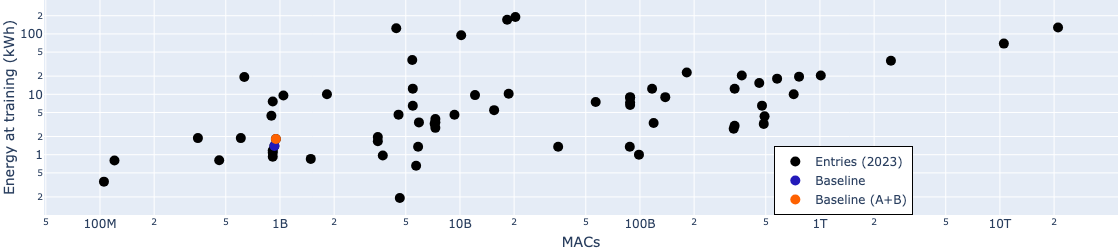

In [663]:
# Define the variables for the scatter plot.
x = 'macs'                          # X-axis data column (MACs)
y = 'energy_training_normalized'     # Y-axis data column (Energy at training)

# Define labels for the x and y axes.
x_axes_lab = 'MACs'
y_axes_lab = 'Energy at training (kWh)'

# Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
fig = scatter_all(df_only_23, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)

# Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
fig.update_layout(
    legend=dict(
        x=0.68,                    # Adjust the x-coordinate to position the legend horizontally
        y=0,                       # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",       # Set the border color (you can use any valid color)
        borderwidth=1,             # Set the border width
    )
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    width=width,                    # Adjust the width as needed
    height=height,                  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
)

# Display the figure.
fig.show()

# Specify the directory for saving the figure and the file name.
file_name = os.path.join(fig_dir, 'macs_tr.png')

# Save the figure to the specified file with a defined format and scaling.
pio.write_image(fig, file_name, format=file_format, scale=3)

add comment - after ICASSP submission

### Relation between MACs and energy at testing

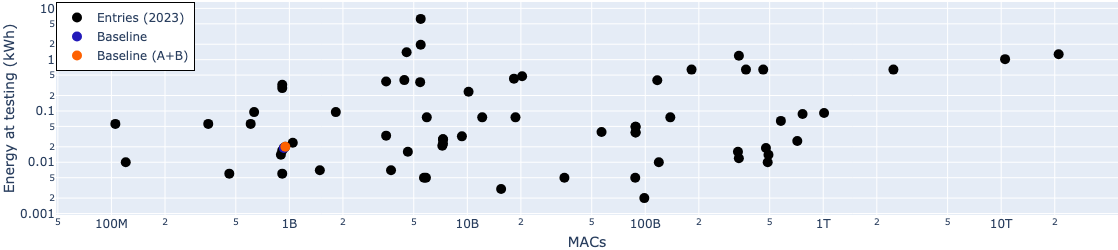

In [664]:
# Define the variable for the y-axis data.
y = 'energy_test_normalized'         # Y-axis data column (Energy at testing)

# Define the label for the y-axis.
y_axes_lab = 'Energy at testing (kWh)'

# Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
fig = scatter_all(df_only_23, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)

# Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
fig.update_layout(
    legend=dict(
        x=0,                        # Adjust the x-coordinate to position the legend horizontally
        y=1,                        # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",        # Set the border color (you can use any valid color)
        borderwidth=1,              # Set the border width
    )
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    width=width,                    # Adjust the width as needed
    height=height,                  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
)

# Display the figure.
fig.show()

# Specify the file name to save the figure with the 'macs_te.png' filename.
file_name = os.path.join(fig_dir, 'macs_te.png')

# Save the figure to the specified file with a defined format and scaling.
pio.write_image(fig, file_name, format=file_format, scale=3)


add comment - after iCASSP submission

## RELATION BETWEEN PERFORMANCE AND ENERGY CONSUMPTION

In [665]:
# Define a list of selected columns from the DataFrame
selected_columns = ['energy_training_normalized', 'energy_test_normalized', 'psds1_eval_full', 'psds2_eval_full', 'macs', 'code', 'system_ensemble_method_subsystem_count']

# Create a subset of the selected columns excluding the last one
subset = selected_columns[:-1]

# Create a new DataFrame 'df_focus_23' by selecting only the specified columns and dropping rows with missing values in the subset
df_focus_23 = df_all_23[selected_columns]
df_focus_23.dropna(subset=subset, inplace=True)

# Define the number of decimal places for rounding
decimal_places = 2

# Round specific columns in 'df_focus_23' to the specified number of decimal places
df_focus_23["psds1_eval_full"] = df_focus_23["psds1_eval_full"].apply(round_to, args=(decimal_places, ))
df_focus_23["psds2_eval_full"] = df_focus_23["psds2_eval_full"].apply(round_to, args=(decimal_places, ))

# Remove duplicate rows in 'df_focus_23' and reset the index
df_focus_23.drop_duplicates(inplace=True)
df_focus_23.reset_index(inplace=True, drop=True)

# Create a new DataFrame 'df_focus_23_ne' containing only rows where 'system_ensemble_method_subsystem_count' is NaN
df_focus_23_ne = df_focus_23[df_focus_23['system_ensemble_method_subsystem_count'].isna()]

# Create a new DataFrame 'df_focus_23_e' containing only rows where 'system_ensemble_method_subsystem_count' is not NaN
df_focus_23_e = df_focus_23[df_focus_23['system_ensemble_method_subsystem_count'].notna()]

# Print the number of entries in different subsets of the DataFrame
print(f"We got a total of {len(df_focus_23)} entries submissions")
print(f"We got a total of {len(df_focus_23_ne)} no-ensemble entries submissions")
print(f"We got a total of {len(df_focus_23_e)} ensemble entries submissions")

We got a total of 86 entries submissions
We got a total of 39 no-ensemble entries submissions
We got a total of 47 ensemble entries submissions


Focusing on only 2023 systems and considering the best performant systems there

In [666]:
# Sort the 'df_focus_23' DataFrame by 'psds1_eval_full' column in descending order to consider the best-performing systems
df_focus_23 = df_focus_23.sort_values(by='psds1_eval_full', ascending=False)

# Select the top 25 systems based on the 'psds1_eval_full' metric
df_focus_23_top = df_focus_23[:25]

# Select the bottom 15 systems based on the 'psds1_eval_full' metric
df_focus_23_bottom = df_focus_23[-25:]

# Reset the index of the top and bottom DataFrames for consistency
df_focus_23_top.reset_index(inplace=True, drop=True)
df_focus_23_bottom.reset_index(inplace=True, drop=True)

In [667]:
# Create a DataFrame 'df_baseline_1' containing rows with 'code' equal to 'Baseline_task4a_1'
df_baseline_1 = df_focus_23[df_focus_23['code'] == 'Baseline_task4a_1']

# Create a DataFrame 'df_baseline_2' containing rows with 'code' equal to 'Baseline_task4a_2'
df_baseline_2 = df_focus_23[df_focus_23['code'] == 'Baseline_task4a_2']

In [668]:
# Remove any trailing numbers in the 'code' column using regular expression replacement - top systems
df_focus_23_top['code'] = df_focus_23_top['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_top' based on selected columns and select the top 15 unique rows
df_top = df_focus_23_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top = pd.concat([df_top, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top' DataFrame for consistency
df_top.reset_index(inplace=True, drop=True)

In [669]:
# Remove any trailing numbers in the 'code' column using regular expression replacement - bottom systems
df_focus_23_bottom['code'] = df_focus_23_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_top' based on selected columns and select the bottom 15 unique rows
df_bot = df_focus_23_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_top' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot = pd.concat([df_bot, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top' DataFrame for consistency
df_bot.reset_index(inplace=True, drop=True)

**PSDS_1 and energy at training** for top systems

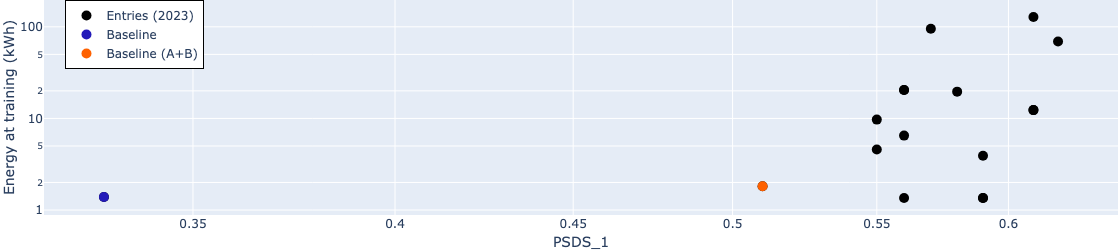

In [670]:
# Define the variables for the scatter plot
x = 'psds1_eval_full'
y = 'energy_training_normalized'
x_axes_lab = 'PSDS_1'
y_axes_lab = 'Energy at training (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'psds1_tr.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)

**PSDS_1 and energy at testing** for top systems

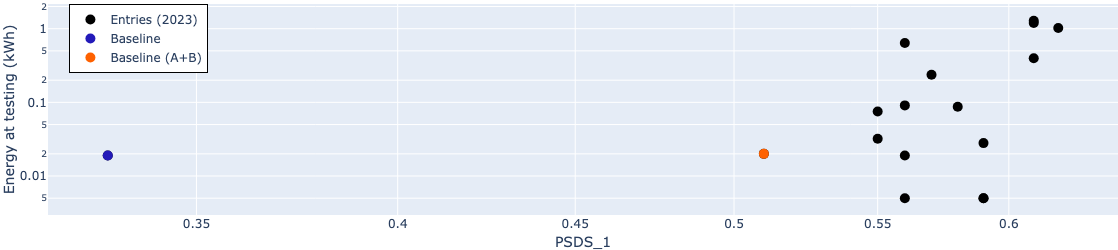

In [671]:
# Define the variable for the scatter plot (Y-axis)
y = 'energy_test_normalized'

# Customize Y-axis label
y_axes_lab = 'Energy at testing (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'psds1_te.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


**PSDS_1 and energy at training** for bottom systems

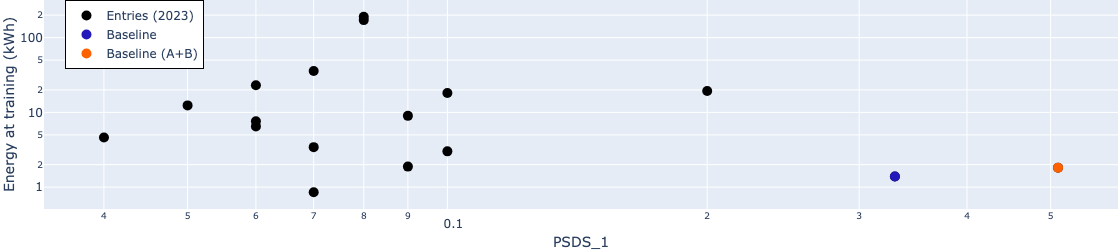

In [672]:
# Define the variable for the scatter plot (Y-axis)
y = 'energy_training_normalized'

# Customize Y-axis label
y_axes_lab = 'Energy at training (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_bot, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'psds1_tr_b.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


**PSDS_1 and energy at testing** for bottom systems

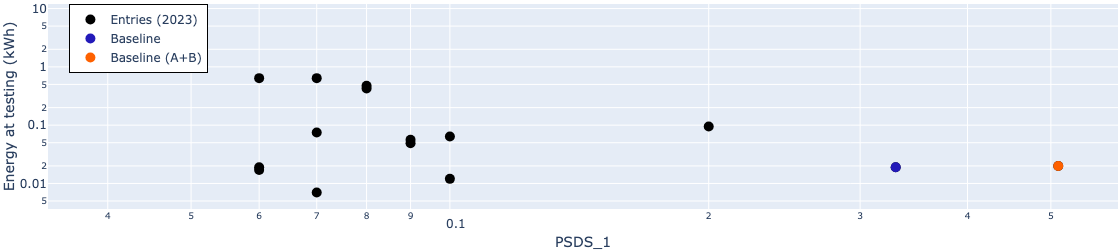

In [673]:
# Define the variable for the scatter plot (Y-axis)
y = 'energy_test_normalized'

# Customize Y-axis label
y_axes_lab = 'Energy at testing (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_bot, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'psds1_te_b.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


**Same for PSDS_2**

In [674]:
# Sort the 'df_focus_23' DataFrame by 'psds2_eval_full' column in descending order to consider the best-performing systems
df_focus_23 = df_focus_23.sort_values(by='psds2_eval_full', ascending=False)

# Select the top 25 systems based on the 'psds2_eval_full' metric
df_focus_23_top = df_focus_23[:25]

# Select the bottom 25 systems based on the 'psds2_eval_full' metric
df_focus_23_bottom = df_focus_23[-25:]

# Reset the index of the top and bottom DataFrames for consistency
df_focus_23_top.reset_index(inplace=True, drop=True)
df_focus_23_bottom.reset_index(inplace=True, drop=True)


In [675]:
# Remove any trailing numbers in the 'code' column using regular expression replacement for the top systems
df_focus_23_top['code'] = df_focus_23_top['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_top' based on selected columns and select the top 15 unique rows
df_top = df_focus_23_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top = pd.concat([df_top, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top' DataFrame for consistency
df_top.reset_index(inplace=True, drop=True)

In [676]:
# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom systems
df_focus_23_bottom['code'] = df_focus_23_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_bottom' based on selected columns and select the bottom 15 unique rows
df_bot = df_focus_23_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot = pd.concat([df_bot, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot' DataFrame for consistency
df_bot.reset_index(inplace=True, drop=True)

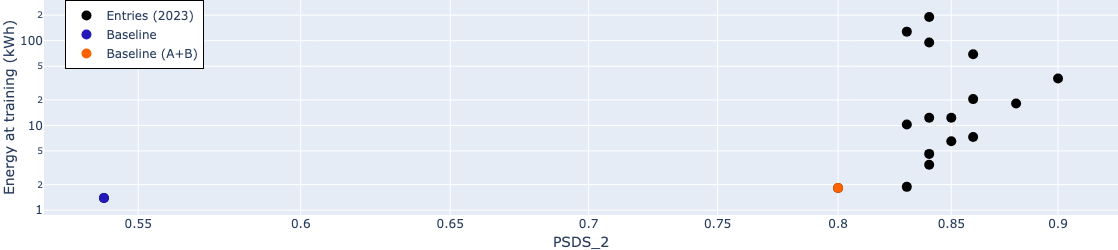

In [677]:
# Define the variables for the scatter plot
x = 'psds2_eval_full'
y = 'energy_training_normalized'
x_axes_lab = 'PSDS_2'
y_axes_lab = 'Energy at training (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'psds2_tr.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)

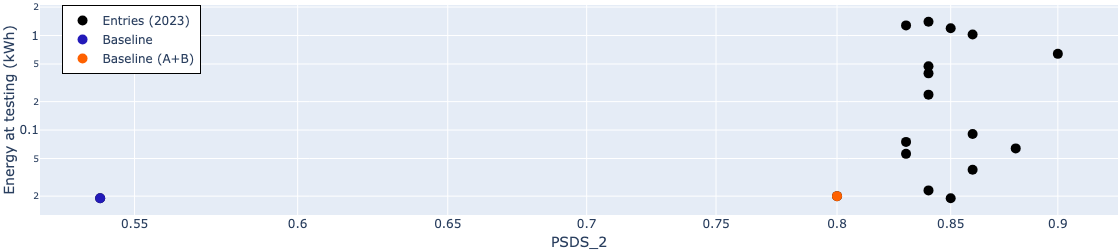

In [678]:
# Define the variable for the scatter plot (Y-axis)
y = 'energy_test_normalized'

# Customize Y-axis label
y_axes_lab = 'Energy at testing (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'psds2_te.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)

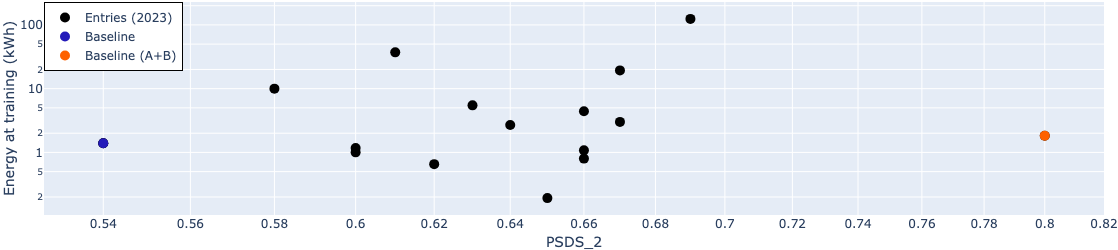

In [679]:
# Define the variables for the scatter plot
y = 'energy_training_normalized'
y_axes_lab = 'Energy at training (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_bot, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.00,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'psds2_tr_b.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)

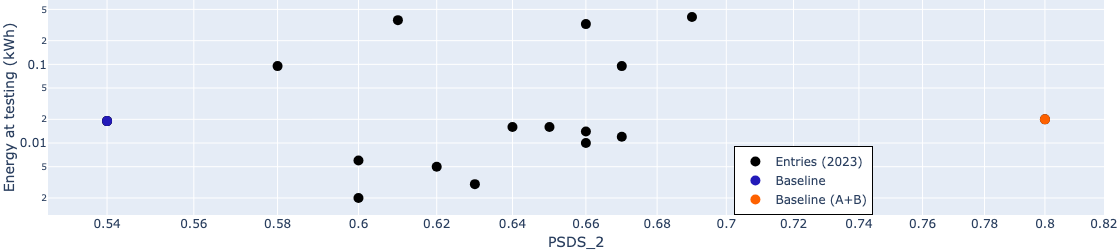

In [680]:
# Define the variable for the scatter plot (Y-axis)
y = 'energy_test_normalized'

# Customize Y-axis label
y_axes_lab = 'Energy at testing (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_bot, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.65,             # Adjust the x-coordinate to position the legend horizontally
        y=0,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'psds2_te_b.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)

#### ANALYSIS OF ENSEMBLE/NON-ENSEMBLE SYSTEMS

**PSDS1**

In [681]:
# For ensemble systems: Select the top 25 systems based on 'psds1_eval_full'
# and the bottom 25 systems based on the same metric
df_focus_23_e = df_focus_23_e.sort_values(by='psds1_eval_full', ascending=False)
df_focus_23_e_top = df_focus_23_e[:25]
df_focus_23_e_bottom = df_focus_23_e[-25:]

# For no-ensemble systems: Select the top 25 systems based on 'psds1_eval_full'
# and the bottom 25 systems based on the same metric
df_focus_23_ne = df_focus_23_ne.sort_values(by='psds1_eval_full', ascending=False)
df_focus_23_ne_top = df_focus_23_ne[:25]
df_focus_23_ne_bottom = df_focus_23_ne[-25:]


In [682]:
# Remove any trailing numbers in the 'code' column using regular expression replacement for the top ensemble systems
df_focus_23_e_top['code'] = df_focus_23_e_top['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the top no-ensemble systems
df_focus_23_ne_top['code'] = df_focus_23_ne_top['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom ensemble systems
df_focus_23_e_bottom['code'] = df_focus_23_e_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom no-ensemble systems
df_focus_23_ne_bottom['code'] = df_focus_23_ne_bottom['code'].str.replace(r'(_\d+)$', '')


In [683]:
# Remove duplicate rows in 'df_focus_23_e_top' based on selected columns and select the top 15 unique rows
df_top_e = df_focus_23_e_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top_e' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top_e = pd.concat([df_top_e, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top_e' DataFrame for consistency
df_top_e.reset_index(inplace=True, drop=True)


# Remove duplicate rows in 'df_focus_23_e_top' based on selected columns and select the bottom 15 unique rows
df_bot_e = df_focus_23_e_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot_e' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot_e = pd.concat([df_bot_e, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot_e' DataFrame for consistency
df_bot_e.reset_index(inplace=True, drop=True)

# Return the resulting 'df_top_e' DataFrame - optional
#df_top_e

In [684]:
# Remove duplicate rows in 'df_focus_23_ne_top' based on selected columns and select the top 15 unique rows
df_top_ne = df_focus_23_ne_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top_ne' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top_ne = pd.concat([df_top_ne, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top_ne' DataFrame for consistency
df_top_ne.reset_index(inplace=True, drop=True)


# Remove duplicate rows in 'df_focus_23_ne_bottom' based on selected columns and select the bottom 15 unique rows
df_bot_ne = df_focus_23_ne_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot_ne' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot_ne = pd.concat([df_bot_ne, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot_ne' DataFrame for consistency
df_bot_ne.reset_index(inplace=True, drop=True)

# Return the resulting 'df_top_ne' DataFrame - optional
#df_top_ne


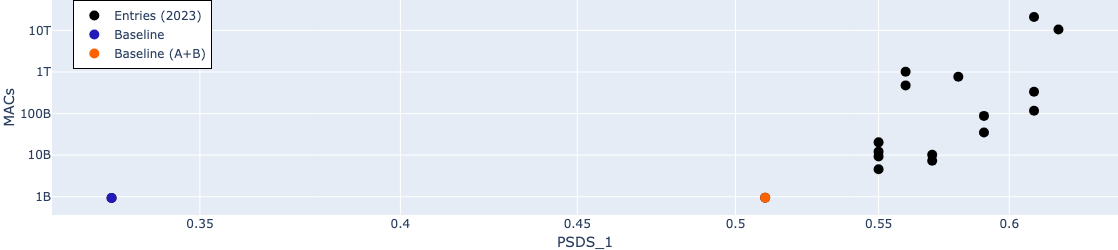

In [685]:
# Define the variables for the scatter plot
x = 'psds1_eval_full' 
y = 'macs'
x_axes_lab = 'PSDS_1'
y_axes_lab = 'MACs'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top_e, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'ens_macs.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


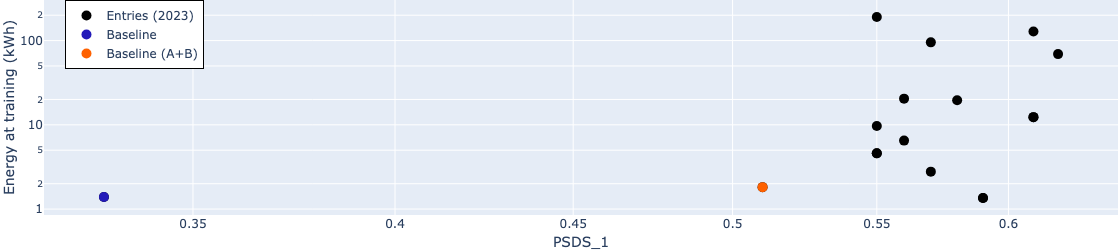

In [686]:
# Define the variables for the scatter plot
x = 'psds1_eval_full' 
y = 'energy_training_normalized'
x_axes_lab = 'PSDS_1'
y_axes_lab = 'Energy at training (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top_e, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'ens_energy.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


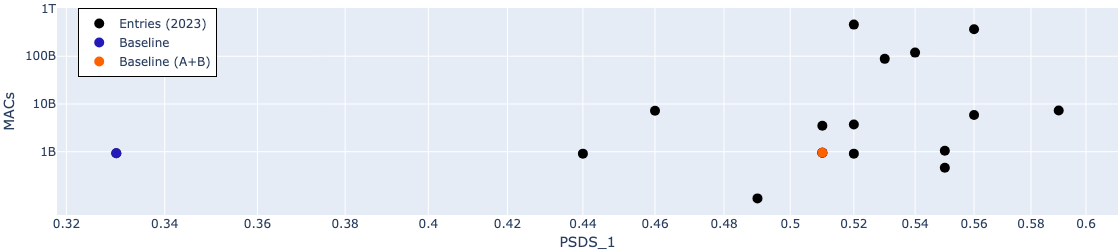

In [687]:
# Define the variables for the scatter plot
x = 'psds1_eval_full' 
y = 'macs'
x_axes_lab = 'PSDS_1'
y_axes_lab = 'MACs'


# Create the scatter plot using the 'scatter_all' function with 'df_top_ne' data and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top_ne, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Customize Y-axis ticks with specified values and labels
custom_y_ticks = [1e9, 1e10, 1e11, 1e12, 1e13]
custom_y_labels = ['1B', '10B', '100B', '1T','10T']
fig.update_yaxes(tickvals=custom_y_ticks, ticktext=custom_y_labels, title="MACs", type='log')

# Display the generated figure
fig.show()

# Define the directory and file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'no_ens_macs.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


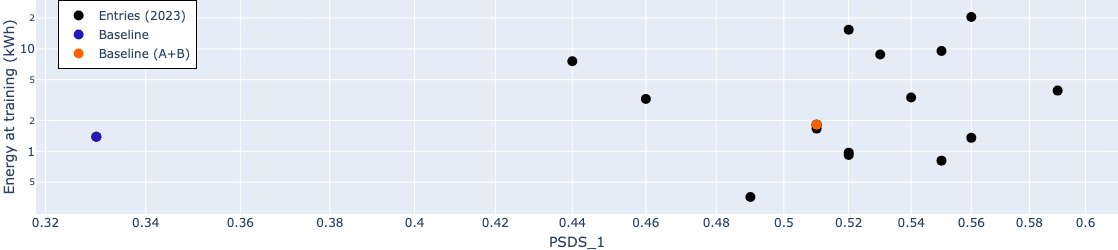

In [688]:
# Define the variables for the scatter plot
x = 'psds1_eval_full' 
y = 'energy_training_normalized'
x_axes_lab = 'PSDS_1'
y_axes_lab = 'Energy at training (kWh)'

# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top_ne, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'noens_energy.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


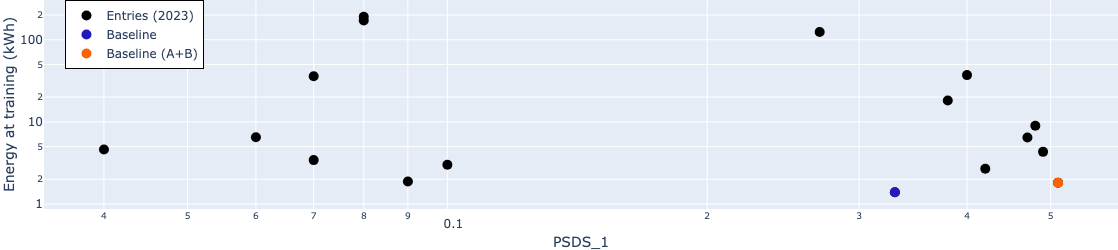

In [689]:
# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_bot_e, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'ens_macs_bot.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


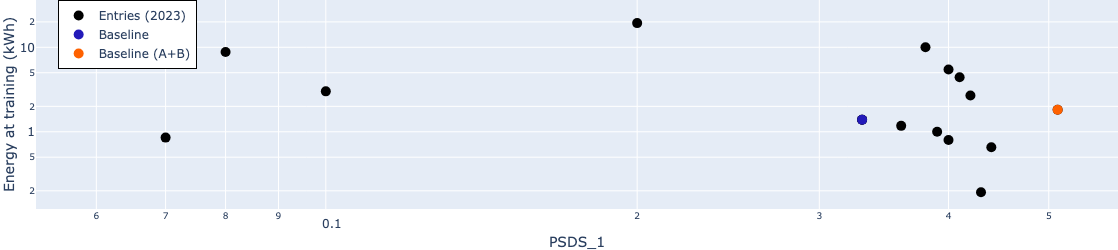

In [690]:
# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_bot_ne, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'no_ens_macs_bot.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


**PSDS_2**

In [691]:
# For ensemble systems: Select the top 25 systems based on 'psds2_eval_full'
# and the bottom 25 systems based on the same metric
df_focus_23_e = df_focus_23_e.sort_values(by='psds2_eval_full', ascending=False)
df_focus_23_e_top = df_focus_23_e[:25]
df_focus_23_e_bottom = df_focus_23_e[-25:]

# For no-ensemble systems: Select the top 25 systems based on 'psds2_eval_full'
# and the bottom 25 systems based on the same metric
df_focus_23_ne = df_focus_23_ne.sort_values(by='psds2_eval_full', ascending=False)
df_focus_23_ne_top = df_focus_23_ne[:25]
df_focus_23_ne_bottom = df_focus_23_ne[-25:]


In [692]:
# Remove any trailing numbers in the 'code' column using regular expression replacement for the top ensemble systems
df_focus_23_e_top['code'] = df_focus_23_e_top['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the top no-ensemble systems
df_focus_23_ne_top['code'] = df_focus_23_ne_top['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom ensemble systems
df_focus_23_e_bottom['code'] = df_focus_23_e_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom no-ensemble systems
df_focus_23_ne_bottom['code'] = df_focus_23_ne_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_e_top' based on selected columns and select the top 15 unique rows
df_top_e = df_focus_23_e_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top_e' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top_e = pd.concat([df_top_e, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top_e' DataFrame for consistency
df_top_e.reset_index(inplace=True, drop=True)


# Remove duplicate rows in 'df_focus_23_e_top' based on selected columns and select the bottom 15 unique rows
df_bot_e = df_focus_23_e_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot_e' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot_e = pd.concat([df_bot_e, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot_e' DataFrame for consistency
df_bot_e.reset_index(inplace=True, drop=True)

# Return the resulting 'df_top_e' DataFrame - optional
#df_top_e

# Remove duplicate rows in 'df_focus_23_ne_top' based on selected columns and select the top 15 unique rows
df_top_ne = df_focus_23_ne_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top_ne' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top_ne = pd.concat([df_top_ne, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top_ne' DataFrame for consistency
df_top_ne.reset_index(inplace=True, drop=True)


# Remove duplicate rows in 'df_focus_23_ne_bottom' based on selected columns and select the bottom 15 unique rows
df_bot_ne = df_focus_23_ne_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot_ne' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot_ne = pd.concat([df_bot_ne, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot_ne' DataFrame for consistency
df_bot_ne.reset_index(inplace=True, drop=True)

# Return the resulting 'df_top_ne' DataFrame - optional
#df_top_ne


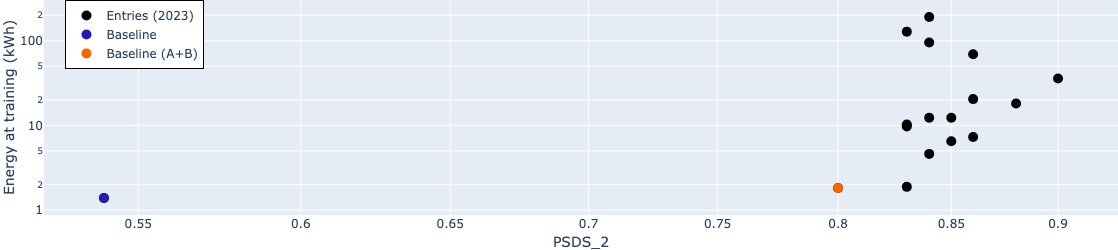

In [693]:
# Define the variables for the scatter plot
x = 'psds2_eval_full' 
x_axes_lab = 'PSDS_2'


# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top_e, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'ens_macs_p2.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


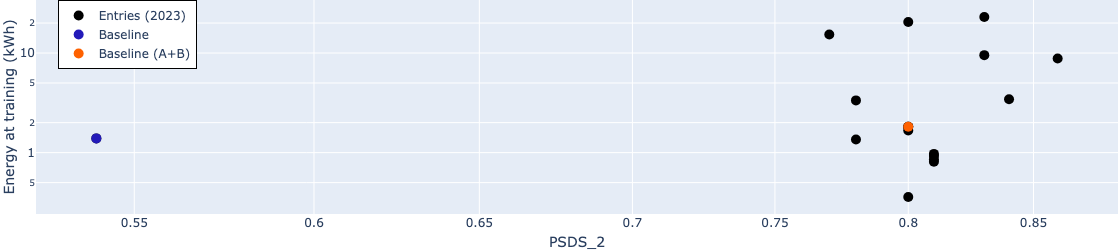

In [694]:
# Define the variables for the scatter plot
x = 'psds2_eval_full' 
x_axes_lab = 'PSDS_2'


# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_top_ne, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'noens_macs_p2.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


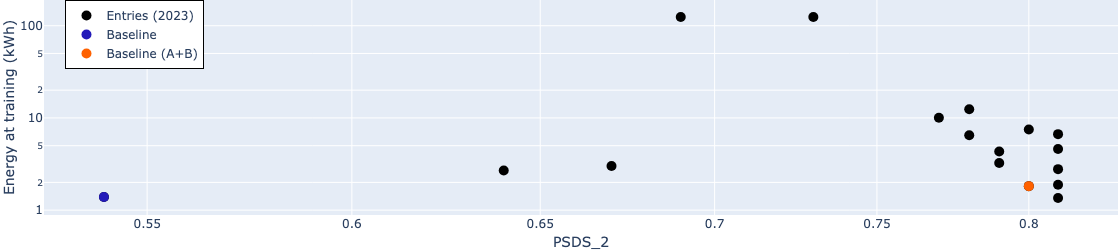

In [695]:
# Define the variables for the scatter plot
x = 'psds2_eval_full' 
x_axes_lab = 'PSDS_2'


# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_bot_e, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'ens_macs_p2_bot.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


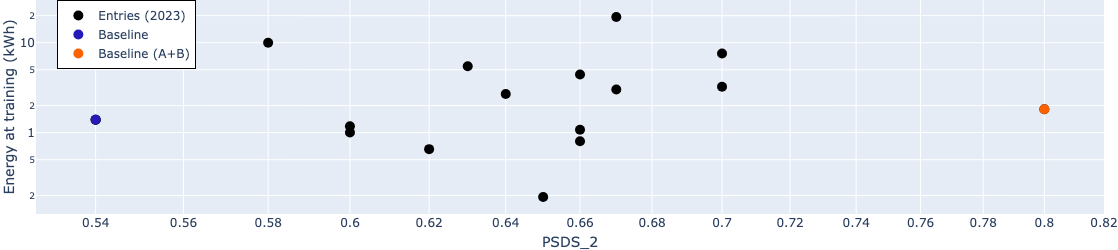

In [696]:
# Define the variables for the scatter plot
x = 'psds2_eval_full' 
x_axes_lab = 'PSDS_2'


# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_bot_ne, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'noens_macs_p2_bot.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)


## CONSIDERING THE WEIGHTED ENERGY

In [707]:
# Commented out code that calculates normalized energy training values and energy weight for training
# since it's not currently in use.
#submission_dict["energy_training_normalized"] = parse_number(important_yaml_data["energy_training"] * base_values['energy_baseline'] / important_yaml_data["energy_baseline"])
#ew_weight_train = base_values['energy_training'] / submission_dict["energy_training_normalized"]

# Define a subset of columns to keep in the 'df_ew_23' DataFrame
subset_columns = ['ew_psds1_eval_full_train', 'ew_psds2_eval_full_train', 'ew_psds1_eval_full_test', 'ew_psds2_eval_full_test', 'psds1_eval_full', 'psds2_eval_full', 'code', 
                 'system_classifier', 'macs', 'system_complexity_time', 'system_data_augmentation', 'system_features', 'pre_trained_models', 'system_ensemble_method_subsystem_count']

# Create 'df_ew_23' DataFrame by selecting specific columns from 'df_all_23'
df_ew_23 = df_all_23[subset_columns]

# Drop duplicates based on selected columns
df_ew_23.drop_duplicates(subset=['ew_psds1_eval_full_train', 'ew_psds1_eval_full_test', 'macs', 'code'], inplace=True)

# Filter out data related to baseline systems for further processing
baseline_1 = df_ew_23[df_ew_23['code'] == 'Baseline_task4a_1']
baseline_2 = df_ew_23[df_ew_23['code'] == 'Baseline_task4a_2']

# Drop rows with code 'Baseline_task4'
df_ew_23.drop(df_ew_23[df_ew_23['code'] == 'Baseline_task4'].index, inplace=True)

# Concatenate 'df_ew_23' with baseline DataFrames
df_ew_23 = pd.concat([df_ew_23, baseline_1, baseline_2])

# Remove any remaining duplicate rows
df_ew_23.drop_duplicates(inplace=True)

# Reset the index of the resulting 'df_ew_23' DataFrame for consistency
df_ew_23.reset_index(inplace=True, drop=True)

# Display the resulting 'df_ew_23' DataFrame - optional
#df_ew_23
df = df_ew_23[['psds1_eval_full', 'ew_psds1_eval_full_train', 'code']]

,psds1_eval_full,ew_psds1_eval_full_train,code
0,0.326,0.325809,Baseline_task4a_1
1,0.508,0.388135,Baseline_task4a_2
2,0.530,0.220050,Li_USTC_task4a_5
3,0.544,0.225819,Li_USTC_task4a_6
4,0.403,0.102302,Li_USTC_task4a_7
...,...,...,...
79,0.611,0.068895,Kim_GIST-HanwhaVision_task4a_8
80,0.553,0.004032,Wenxin_TJU_task4a_1
81,0.569,0.008297,Wenxin_TJU_task4a_2
82,0.077,0.000621,Wenxin_TJU_task4a_3


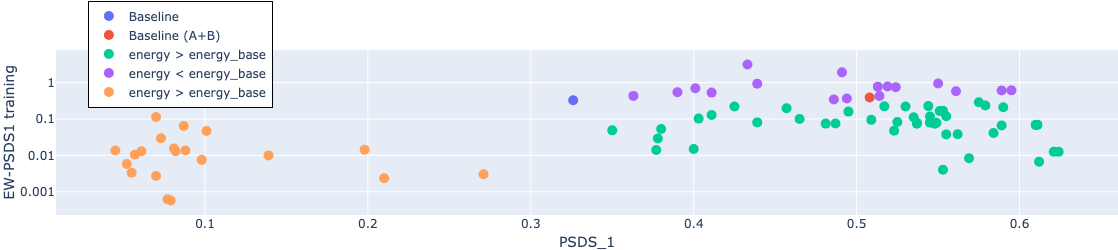

In [767]:
# Filter rows based on your conditions
baseline_row = df[df['code'] == 'Baseline_task4a_1']
baseline_psds1_eval_full = baseline_row['psds1_eval_full'].iloc[0]
baseline_ew_psds1_eval_full_train = baseline_row['ew_psds1_eval_full_train'].iloc[0]

# Create a new column for colors based on conditions
df['color'] = 'gray'  # Default color (gray)


df.loc[(df['psds1_eval_full'] > baseline_psds1_eval_full) & (df['ew_psds1_eval_full_train'] > baseline_ew_psds1_eval_full_train), 'color'] = 'blue'
df.loc[(df['psds1_eval_full'] > baseline_psds1_eval_full) & (df['ew_psds1_eval_full_train'] < baseline_ew_psds1_eval_full_train), 'color'] = 'yellow'
df.loc[(df['psds1_eval_full'] < baseline_psds1_eval_full) & (df['ew_psds1_eval_full_train'] > baseline_ew_psds1_eval_full_train), 'color'] = 'green'
df.loc[(df['psds1_eval_full'] < baseline_psds1_eval_full) & (df['ew_psds1_eval_full_train'] < baseline_ew_psds1_eval_full_train), 'color'] = 'pink'

df.loc[(df['code']=='Baseline_task4a_2'), 'color'] = 'black'
# Create a scatter plot using Plotly Express
fig = px.scatter(df, x='psds1_eval_full', y='ew_psds1_eval_full_train', color='color')  # Rename the legend label)

# Update plot labels and title
fig.update_layout(
    xaxis_title='psds1_eval_full',
    yaxis_title='ew_psds1_eval_full_train',
)

fig.update_traces(marker=dict(size=10))

# Update legend position and entries
fig.update_layout(
    legend=dict(
        x=0.03,  # Adjust the x-coordinate to move legend inside
        y=1.3,  # Adjust the y-coordinate to move legend inside
        bordercolor="black",       # Set the border color (you can use any valid color)
        borderwidth=1,   
    ),
    width=500,            # Adjust the width as needed
    height=250,
    legend_title_text=None,  # Remove the legend title
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    width=width,                    # Adjust the width as needed
    height=height,                  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
)

fig.update_traces(name='Baseline', selector=dict(name='gray'))
fig.update_traces(name='Baseline (A+B)', selector=dict(name='black'))
fig.update_traces(name='energy < energy_base', selector=dict(name='blue'))
fig.update_traces(name='energy > energy_base', selector=dict(name='yellow'))
fig.update_traces(name='energy > energy_base', selector=dict(name='pink'))

# Update x-axis and y-axis labels
fig.update_xaxes(title_text='PSDS_1')
fig.update_yaxes(title_text='EW-PSDS1 training', type='log')

# Show the plot
fig.show()

pio.write_image(fig, './ew_psds1.png', format=file_format, scale=3)

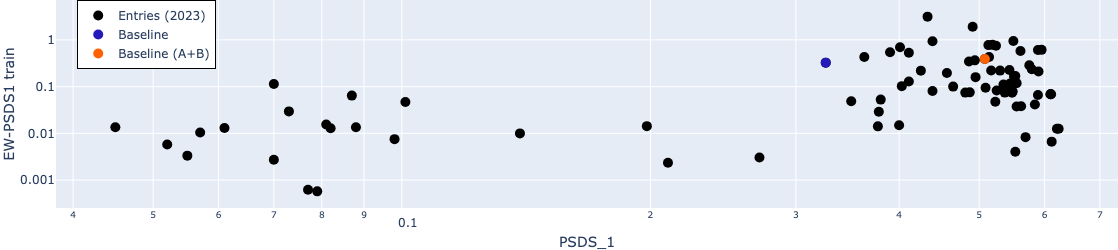

In [703]:
# Define some variable names for labels and titles
x = 'psds1_eval_full'             # Label for the x-axis data in the first plot
y = 'ew_psds1_eval_full_train'    # Label for the y-axis data in the first plot
x_axes_lab = 'PSDS_1'                # Label for the x-axis in the first plot
y_axes_lab = 'EW-PSDS1 train'         # Label for the y-axis in the first plot

# Common variables for both plots
code = 'code'                         # A code label
title = 'PSDS - EW-PSDS training'     # Title for the first plot


# Create the scatter plot using the 'scatter_all' function and customize labels, legend, layout, and dimensions
fig = scatter_all(df_ew_23, x, y, x_axes_lab, y_axes_lab, code, add_base=True, show=False)
fig.update_layout(
    legend=dict(
        x=0.02,             # Adjust the x-coordinate to position the legend horizontally
        y=1,                # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",# Set the border color (you can use any valid color)
        borderwidth=1,      # Set the border width
    )
)
fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,            # Adjust the width as needed
    height=height,          # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

# Display the generated figure
fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'XXX.png')

# Save the figure to the specified file with the specified format and scale
#pio.write_image(fig, file_name, format=file_format, scale=3)


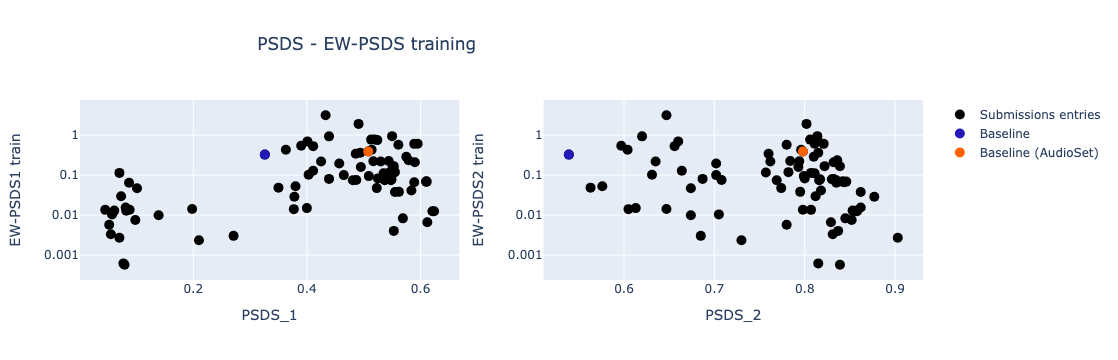

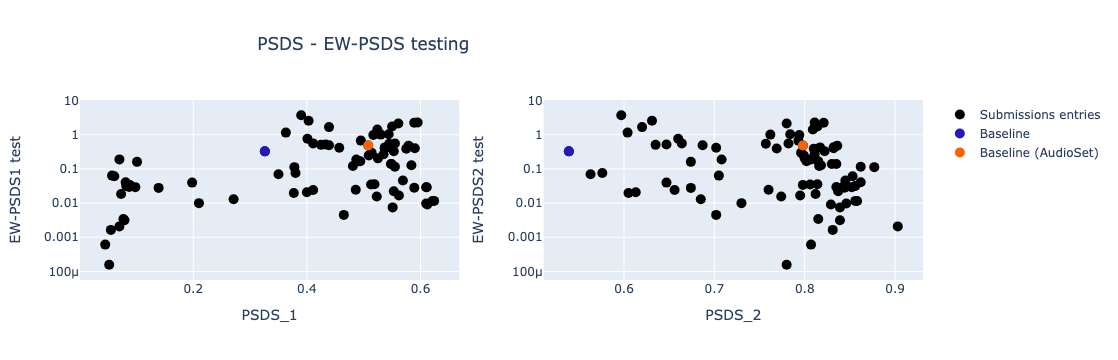

In [700]:
# Define some variable names for labels and titles
x_lab = 'psds1_eval_full'             # Label for the x-axis data in the first plot
y_lab = 'ew_psds1_eval_full_train'    # Label for the y-axis data in the first plot
x_axes_lab = 'PSDS_1'                # Label for the x-axis in the first plot
y_axes_lab = 'EW-PSDS1 train'         # Label for the y-axis in the first plot

# Define some more variable names for the second set of data
x_lab_2 = 'psds2_eval_full'           # Label for the x-axis data in the second plot
x_axes_lab_2 = 'PSDS_2'              # Label for the x-axis in the second plot
y_axes_lab_2 = 'EW-PSDS2 train'      # Label for the y-axis in the second plot

# Common variables for both plots
code = 'code'                         # A code label
title = 'PSDS - EW-PSDS training'     # Title for the first plot

# Call the 'scatter_compare' function with the first set of parameters
scatter_compare(
    df_ew_23,                         # Dataframe 'df_ew_23'
    df_ew_23,                         # Dataframe 'df_ew_23' (probably a mistake?)
    x_lab,                            # x-axis data for the first plot
    y_lab,                            # y-axis data for the first plot
    x_axes_lab,                       # Label for x-axis in the first plot
    y_axes_lab,                       # Label for y-axis in the first plot
    code,                             # Code label
    title,                            # Title for the first plot
    x_lab_2=x_lab_2,                  # Additional x-axis data for the second plot
    y_lab_2=y_lab,                    # Additional y-axis data for the second plot (probably a mistake?)
    x_axes_lab_2=x_axes_lab_2,        # Label for x-axis in the second plot
    y_axes_lab_2=y_axes_lab_2,        # Label for y-axis in the second plot
    type_yaxes='log',                 # Type of y-axis scale (logarithmic)
    add_base=True,                    # Some flag, possibly related to adding a base
    year='2023'                       # Year information
)

# Update some variables for the second plot
y_lab = 'ew_psds1_eval_full_test'     # Updated y-axis data for the second plot
y_axes_lab = 'EW-PSDS1 test'          # Updated label for y-axis in the second plot
y_axes_lab_2 = 'EW-PSDS2 test'        # Updated label for y-axis in the second plot
title = 'PSDS - EW-PSDS testing'      # Updated title for the second plot

# Call the 'scatter_compare' function again with the updated parameters
fig = scatter_compare(
    df_ew_23,                         # Dataframe 'df_ew_23'
    df_ew_23,                         # Dataframe 'df_ew_23' (probably a mistake?)
    x_lab,                            # x-axis data for the second plot (same as first)
    y_lab,                            # y-axis data for the second plot (updated)
    x_axes_lab,                       # Label for x-axis in the second plot (same as first)
    y_axes_lab,                       # Label for y-axis in the second plot (updated)
    code,                             # Code label
    title,                            # Title for the second plot (updated)
    x_lab_2=x_lab_2,                  # Additional x-axis data for the second plot (same as first)
    y_lab_2=y_lab,                    # Additional y-axis data for the second plot (probably a mistake?)
    x_axes_lab_2=x_axes_lab_2,        # Label for x-axis in the second plot (same as first)
    y_axes_lab_2=y_axes_lab_2,        # Label for y-axis in the second plot (updated)
    type_yaxes='log',                 # Type of y-axis scale (logarithmic)
    add_base=True,                    # Some flag, possibly related to adding a base
    year='2023',                       # Year information
    show=False
)

fig.show()

# Define the file name for saving the figure as an image
file_name = os.path.join(fig_dir, 'ew-psds-all.png')

# Save the figure to the specified file with the specified format and scale
pio.write_image(fig, file_name, format=file_format, scale=3)

In [ ]:
metric = 'psds1_eval_full'
df_ew_23.sort_values(by=metric, inplace=True, ascending=False)
#df_we_23_top_p1 = pd.concat([df_we_23, baseline_1, baseline_2])
df_ew_23_top_p1 = df_ew_23[:25]
df_ew_23_top_p1.reset_index(inplace=True, drop=True)

#df_we_23_bottom_p1 = pd.concat([df_we_23[-15:], baseline_1, baseline_2])
df_ew_23_bottom_p1 = df_ew_23[-25:]
df_ew_23_bottom_p1.reset_index(inplace=True, drop=True)

metric = 'psds2_eval_full'
df_ew_23.sort_values(by=metric, inplace=True, ascending=False)
#df_ew_23_top_p2 = pd.concat([df_ew_23[:15], baseline_1, baseline_2])
df_ew_23_top_p2 = df_ew_23[:25]
df_ew_23_top_p2.reset_index(inplace=True, drop=True)

#df_ew_23_bottom_p2 = pd.concat([df_ew_23[-15:], baseline_1, baseline_2])
df_ew_23_bottom_p2 = df_ew_23[-25:]
df_ew_23_bottom_p2.reset_index(inplace=True, drop=True)

In [ ]:
df_ew_23_top_p1['code'] = df_ew_23_top_p1['code'].str.replace(r'(_\d+)$', '')
df_ew_23_bottom_p1['code'] = df_ew_23_bottom_p1['code'].str.replace(r'(_\d+)$', '')
df_ew_23_top_p2['code'] = df_ew_23_top_p2['code'].str.replace(r'(_\d+)$', '')
df_ew_23_bottom_p2['code'] = df_ew_23_bottom_p2['code'].str.replace(r'(_\d+)$', '')

**PSDS1**

In [ ]:
df_top = df_ew_23_top_p1.drop_duplicates(subset=['macs', 'code'])[:15]
df_down = df_ew_23_bottom_p1.drop_duplicates(subset=['macs', 'code'])[-15:]

df_top = pd.concat([df_top, baseline_1, baseline_2])
df_top.reset_index(inplace=True, drop=True)

df_down.reset_index(inplace=True, drop=True)
#df_down

In [ ]:
# system complexity VS macs
x = 'psds1_eval_full' 
y = 'ew_psds1_eval_full_train'

x_axes_lab = 'PSDS_1'
y_axes_lab = 'EW-PSDS1 training'

fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, type_xaxes='linear', type_yaxes='linear', add_base=True, show=False)

# add the bootom
fig.add_trace(
        go.Scatter(
                x=df_down[x],
                y=df_down[y],
                text=df_down[code],
                type= 'scatter',
                mode= 'markers',
                name= 'Entries (2023)',
                marker_size=10,
                marker= {'color': '#9FC592'},
            ),
        row=1, col=1
    )


fig.update_layout(
    legend=dict(
        x=0.02,  # Adjust the x-coordinate to position the legend horizontally
        y=1,  # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",  # Set the border color (you can use any valid color)
        borderwidth=1,        # Set the border width
    )
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,  # Adjust the width as needed
    height=height,  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

fig.show()

file_name = os.path.join(fig_dir, 'ew_psds1.png')
# Save the figure to the specified file
pio.write_image(fig, file_name, format=file_format, scale=3)

In [ ]:
# system complexity VS macs
x = 'psds1_eval_full' 
y = 'ew_psds1_eval_full_test'

x_axes_lab = 'PSDS_1'
y_axes_lab = 'EW-PSDS1 testing'

fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, type_xaxes='linear', type_yaxes='linear', add_base=True, show=False)

# add the bootom
fig.add_trace(
        go.Scatter(
                x=df_down[x],
                y=df_down[y],
                text=df_down[code],
                type= 'scatter',
                mode= 'markers',
                name= 'Entries (2023)',
                marker_size=10,
                marker= {'color': '#9FC592'},
            ),
        row=1, col=1
    )


fig.update_layout(
    legend=dict(
        x=0.02,  # Adjust the x-coordinate to position the legend horizontally
        y=1,  # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",  # Set the border color (you can use any valid color)
        borderwidth=1,        # Set the border width
    )
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,  # Adjust the width as needed
    height=height,  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

fig.show()

file_name = os.path.join(fig_dir, 'ew_psds1_te.png')
# Save the figure to the specified file
pio.write_image(fig, file_name, format=file_format, scale=3)

**PSDS2**

In [ ]:
df_top = df_ew_23_top_p2.drop_duplicates(subset=['macs', 'code'])[:15]
df_down = df_ew_23_bottom_p2.drop_duplicates(subset=['macs', 'code'])[-15:]

df_top = pd.concat([df_top, baseline_1, baseline_2])
df_top.reset_index(inplace=True, drop=True)

df_down.reset_index(inplace=True, drop=True)
#df_down

In [ ]:
# system complexity VS macs
x = 'psds2_eval_full' 
y = 'ew_psds2_eval_full_train'

x_axes_lab = 'PSDS_2'
y_axes_lab = 'EW-PSDS2 training'

fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, type_xaxes='linear', type_yaxes='log', add_base=True, show=False)

# add the bootom
fig.add_trace(
        go.Scatter(
                x=df_down[x],
                y=df_down[y],
                text=df_down[code],
                type= 'scatter',
                mode= 'markers',
                name= 'Entries (2023)',
                marker_size=10,
                marker= {'color': '#9FC592'},
            ),
        row=1, col=1
    )


fig.update_layout(
    legend=dict(
        x=0.8,  # Adjust the x-coordinate to position the legend horizontally
        y=1,  # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",  # Set the border color (you can use any valid color)
        borderwidth=1,        # Set the border width
    )
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,  # Adjust the width as needed
    height=height,  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

fig.show()

file_name = os.path.join(fig_dir, 'ew_psds2.png')
# Save the figure to the specified file
pio.write_image(fig, file_name, format=file_format, scale=3)

In [ ]:
# system complexity VS macs
x = 'psds2_eval_full' 
y = 'ew_psds2_eval_full_test'

x_axes_lab = 'PSDS_2'
y_axes_lab = 'EW-PSDS2 testing'

fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, type_xaxes='linear', type_yaxes='log', add_base=True, show=False)

# add the bootom
fig.add_trace(
        go.Scatter(
                x=df_down[x],
                y=df_down[y],
                text=df_down[code],
                type= 'scatter',
                mode= 'markers',
                name= 'Entries (2023)',
                marker_size=10,
                marker= {'color': '#9FC592'},
            ),
        row=1, col=1
    )


fig.update_layout(
    legend=dict(
        x=0.8,  # Adjust the x-coordinate to position the legend horizontally
        y=1,  # Adjust the y-coordinate to position the legend vertically
        bordercolor="black",  # Set the border color (you can use any valid color)
        borderwidth=1,        # Set the border width
    )
)

fig.update_layout(
    xaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,  # Remove spacing between label and axis
    ),
    width=width,  # Adjust the width as needed
    height=height,  # Adjust the height as needed
    margin=dict(l=0, r=0, t=0, b=0.5),
)

fig.show()

file_name = os.path.join(fig_dir, 'ew_psds2_te.png')
# Save the figure to the specified file
pio.write_image(fig, file_name, format=file_format, scale=3)

## THRESHOLDING AALYSIS

In [ ]:
# Define a list of column names that we care about
columns_name = ['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params', 'system_ensemble_method_subsystem_count', 'code', 'psds1_eval_full', 'psds2_eval_full']

# Define a subset of column names that we want to keep
subset = ['system_complexity_params', 'energy_training_normalized', 'energy_test_normalized']

# Create a new DataFrame 'df_th' containing only the columns specified in 'columns_name'
df_th = df_all_23[columns_name]

# Remove duplicate rows in 'df_th' based on the values in the 'subset' columns
df_th.drop_duplicates(subset=subset, inplace=True)

# Reset the index of 'df_th' after removing duplicates and drop the old index
df_th.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_th'
# print_df(df_th)


In [ ]:
# Create a new DataFrame 'df_23_not_ensembled' containing rows where 'system_ensemble_method_subsystem_count' is NaN (not ensembled)
df_23_not_ensembled = df_th[df_th.system_ensemble_method_subsystem_count.isna()]

# Create a new DataFrame 'df_23_ensembled' containing rows where 'system_ensemble_method_subsystem_count' is not NaN (ensembled)
df_23_ensembled = df_th[~df_th.system_ensemble_method_subsystem_count.isna()]

# Print the number of ensembled and not ensembled systems
print(f"Number of ensembled systems: {len(df_23_ensembled)}")
print(f"Number of not ensembled systems: {len(df_23_not_ensembled)}")


In [ ]:
# Define the metric of interest
metric = 'energy_training_normalized'

# Calculate the median value for 'energy_training_normalized' in the ensembled systems
median_energy_training_normalized = df_23_ensembled[metric].quantile(0.75)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df_23_ensembled[df_23_ensembled[metric] > median_energy_training_normalized]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df_23_ensembled[df_23_ensembled[metric] < median_energy_training_normalized]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at training normalized is: {median_energy_training_normalized:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under threshold")

# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

In [ ]:
# Define the metric of interest
metric = 'energy_test_normalized'

# Calculate the median value for 'energy_training_normalized' in the ensembled systems
median_energy_test_normalized = df_23_ensembled[metric].quantile(0.75)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df_23_ensembled[df_23_ensembled[metric] > median_energy_test_normalized]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df_23_ensembled[df_23_ensembled[metric] < median_energy_test_normalized]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at training normalized is: {median_energy_test_normalized:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under threshold")

# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

In [ ]:
# Define the metric of interest
metric = 'macs'

# Calculate the median value for 'energy_training_normalized' in the ensembled system
median_MACs = df_23_ensembled[metric].quantile(0.75)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df_23_ensembled[df_23_ensembled[metric] > median_MACs]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df_23_ensembled[df_23_ensembled[metric] < median_MACs]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at training normalized is: {median_MACs:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under threshold")

# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

In [ ]:
# Define the metric of interest
metric = 'system_complexity_params'

# Calculate the median value for 'energy_training_normalized' in the ensembled systems
median_sc = df_23_ensembled[metric].quantile(0.75)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df_23_ensembled[df_23_ensembled[metric] > median_sc]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df_23_ensembled[df_23_ensembled[metric] < median_sc]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for system complexity params is: {median_sc:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under threshold")

# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

In [ ]:
# above threshold metrics for ensemble systems
df_above_threshold[['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params']].describe().applymap(custom_format)

In [ ]:
# Sort the 'df_under_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_under_threshold' after sorting and drop the old index
df_under_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_under_threshold'
# df_under_threshold

# Calculate summary statistics for specific columns of the 'df_under_threshold' DataFrame
# and apply a custom formatting function (assumed to be named 'custom_format')
df_under_threshold[['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params']].describe().applymap(custom_format)

# The 'describe' method computes statistics like count, mean, std, min, 25%, 50%, 75%, and max
# for the specified columns and formats the results using 'custom_format'.

# Uncomment the following line to print the summary statistics for the specified columns
# print(summary_stats)


In [ ]:
# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds2_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
# df_above_threshold

**Not ensemble systems**

In [ ]:
# Assign the DataFrame 'df_23_not_ensembled' to 'df'
df = df_23_not_ensembled

# Define the metric of interest
metric = 'energy_training_normalized'

# Calculate the median value for 'energy_training_normalized'
median_energy_training_normalized = df[metric].quantile(0.75)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df[df[metric] > median_energy_training_normalized]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df[df[metric] < median_energy_training_normalized]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at training normalized is: {median_energy_training_normalized:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under the threshold")
# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

In [ ]:
# Assign the DataFrame 'df_23_not_ensembled' to 'df'
df = df_23_not_ensembled

# Define the metric of interest
metric = 'energy_test_normalized'

# Calculate the median value for 'energy_training_normalized'
median_energy_test_normalized = df[metric].quantile(0.75)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df[df[metric] > median_energy_test_normalized]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df[df[metric] < median_energy_test_normalized]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at testing normalized is: {median_energy_test_normalized:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under the threshold")
# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

In [ ]:
# Assign the DataFrame 'df_23_not_ensembled' to 'df'
df = df_23_not_ensembled

# Define the metric of interest
metric = 'macs'

# Calculate the median value for 'energy_training_normalized'
median_macs = df[metric].quantile(0.75)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df[df[metric] > median_macs]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df[df[metric] < median_macs]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for MACs is: {median_macs:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under the threshold")
# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

In [ ]:
# Assign the DataFrame 'df_23_not_ensembled' to 'df'
df = df_23_not_ensembled

# Define the metric of interest
metric = 'system_complexity_params'

# Calculate the median value for 'energy_training_normalized'
median_sc = df[metric].quantile(0.75)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df[df[metric] > median_sc]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df[df[metric] < median_sc]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for MACs is: {median_sc:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under the threshold")
# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

In [ ]:
# above threshold for not ensembled systems
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_above_threshold.reset_index(inplace=True, drop=True)
df_above_threshold

In [ ]:
# above threshold metrics for not ensembled systems
df_above_threshold[['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params']].describe().applymap(custom_format)

In [ ]:
# under threshold for not ensembled systems
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold.reset_index(inplace=True, drop=True)
df_under_threshold

In [ ]:
# under threshold metrics for not ensembled systems
df_under_threshold[['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params']].describe().applymap(custom_format)